# Steel Plate Defect Prediction

In [31]:
!pip install iterative-stratification

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [33]:
import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,train_test_split
from sklearn.pipeline import Pipeline

# Models
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, RepeatedMultilabelStratifiedKFold
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import numpy as np

In [28]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)
submission = pd.read_csv('data/sample_submission.csv',index_col=0)

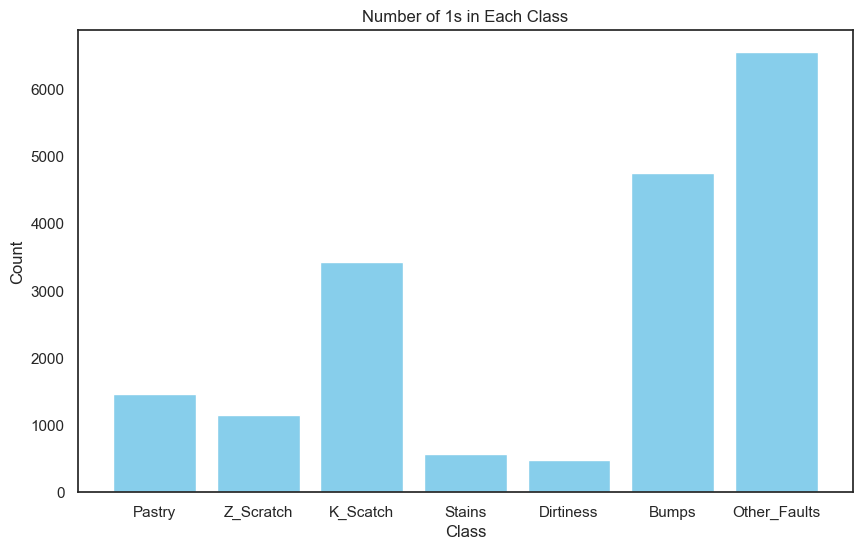

In [29]:
#let's check the label variables.

# Define the labels
labels = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']

# Count the number of 1s in each class
counts = [train[label].sum() for label in labels]

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(labels, counts, color='skyblue')
plt.title('Number of 1s in Each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [30]:
X = train.iloc[:,:-7]
y = train.iloc[:,-7:]